## Описание проекта

### Общая информация

Клиентам компании «Мегалайн» (федерального оператора сотовой связи) предлагают два тарифных плана: «Смарт» и «Ультра». 

Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, **какой тариф приносит больше денег**.

В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

**Описание тарифов**

**Тариф «Смарт»**

Ежемесячная плата: 550 рублей

Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика

Стоимость услуг сверх тарифного пакета:

минута разговора: 3 рубля

сообщение: 3 рубля

1 Гб интернет-трафика: 200 рублей

**Тариф «Ультра»**

Ежемесячная плата: 1950 рублей

Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика

Стоимость услуг сверх тарифного пакета:

минута разговора: 1 рубль

сообщение: 1 рубль

1 Гб интернет-трафика: 150 рублей

**Примечание**

«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.

Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта. Неиспользованные за предыдущий месяц звонки, смс, интернет на следующий месяц не переносятся.

### Описание данных

**Таблица users** (информация о пользователях):
- *user_id* — уникальный идентификатор пользователя
- *first_name* — имя пользователя
- *last_name* — фамилия пользователя
- *age* — возраст пользователя (годы)
- *reg_date* — дата подключения тарифа (день, месяц, год)
- *churn_date* — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- *city* — город проживания пользователя
- *tariff* — название тарифного плана

**Таблица calls** (информация о звонках):
- *id* — уникальный номер звонка
- *call_date* — дата звонка
- *duration* — длительность звонка в минутах
- *user_id* — идентификатор пользователя, сделавшего звонок

**Таблица messages** (информация о сообщениях):
- *id* — уникальный номер сообщения
- *message_date* — дата сообщения
- *user_id* — идентификатор пользователя, отправившего сообщение

**Таблица internet** (информация об интернет-сессиях):
- *id* — уникальный номер сессии
- *mb_used* — объём потраченного за сессию интернет-трафика (в мегабайтах)
- *session_date* — дата интернет-сессии
- *user_id* — идентификатор пользователя

**Таблица tariffs** (информация о тарифах):
- *tariff_name* — название тарифа
- *rub_monthly_fee* — ежемесячная абонентская плата в рублях
- *minutes_included* — количество минут разговора в месяц, включённых в абонентскую плату
- *messages_included* — количество сообщений в месяц, включённых в абонентскую плату
- *mb_per_month_included* — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- *rub_per_minute* — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- *rub_per_message* — стоимость отправки сообщения сверх тарифного пакета
- *rub_per_gb* — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

## Предобработка

Загружаем нужные библиотеки

In [1]:
import pandas as pd
import math
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt

Создаём датафреймы из csv-файлов с данными

In [2]:
try:
    users = pd.read_csv('users.csv')
    calls = pd.read_csv('calls.csv')
    internet = pd.read_csv('internet.csv')
    messages = pd.read_csv('messages.csv')
    tariffs = pd.read_csv('tariffs.csv')
except:
    users = pd.read_csv('/datasets/users.csv')
    calls = pd.read_csv('/datasets/calls.csv')
    internet = pd.read_csv('/datasets/internet.csv')
    messages = pd.read_csv('/datasets/messages.csv')
    tariffs = pd.read_csv('/datasets/tariffs.csv')

### Знакомство с данными и поиск проблем

Рассмотрим каждый датафрейм с помощью метода **info()** и взглянем визуально на 10 случайных строк из него. Проверим на дубликаты там, где они могут быть.

#### Датафрейм *users*

Кроме общих действий, полезно узнать, повторяются ли значения в столбце *user_id* и в столбцах с возрастом, городом, фамилией и именем. Это нужно, чтобы исключить запись одного и того же человека под разными id

In [3]:
users.info()
display(users.sample(10))
# посчитаем дубликаты в отдельной переменной, для удобства использования f-строки
users_id_duplicated = users.duplicated(subset='user_id').sum()
print(f'Количество явных дубликатов в столбце user_id: {users_id_duplicated}')
users_duplicated = users.duplicated(subset=['age', 'city', 'first_name', 'last_name']).sum()
print(f'Количество явных дубликатов в датафрейме users: {users_duplicated}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
336,1336,27,NaN,Уфа,Авксентий,Алексеичев,2018-12-31,ultra
440,1440,51,NaN,Москва,Арсений,Матвеев,2018-05-28,ultra
39,1039,40,NaN,Ярославль,Агнесса,Андреенко,2018-06-21,ultra
77,1077,18,NaN,Москва,Марица,Кольцова,2018-10-23,smart
485,1485,34,NaN,Киров,Таисия,Сухова,2018-12-29,ultra
275,1275,48,NaN,Москва,Семён,Елизаров,2018-04-24,smart
439,1439,62,NaN,Орёл,Евгения,Афонина,2018-06-30,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
316,1316,42,NaN,Улан-Удэ,Аурелия,Алымова,2018-11-29,smart
181,1181,37,NaN,Омск,Рем,Аврорин,2018-11-23,smart


Количество явных дубликатов в столбце user_id: 0
Количество явных дубликатов в датафрейме users: 0


Учитывая, что задача стоит определить более выгодный тариф, думаю, что информация из столбца *churn_date* нам не понадобится. Как и ФИО пользователя. Поэтому из этого датафрейма будем использовать только информацию из столбцов *user_id, city, tariff*, в которых пропусков нет.

Также думаю, что дата регистрации не понадобится, так как судя по описанию данных, в других таблицах есть дата использования элементов тарифа, которая нам и подскажет, когда пользователь начал пользоваться им. 

Да возможна ситуация, в которой человек подключив тариф, не успел чем-либо воспользоваться в конкретном месяце, но не думаю, что это будет слишком часто, чтобы поставить под сомнение результат исследования.

Дубликатов в столбце *user_id* нет, как и во всём датафрейме. Вцелом отличный исходник ведь! :-)

#### Датафрейм *calls*

В данном случае кроме общих действий, поищем явные дубликаты

In [4]:
calls.info()
display(calls.sample(10))
print(f'Количество явных дубликатов в датафрейме calls: {calls.duplicated().sum()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
131870,1339_199,2018-09-07,9.91,1339
110878,1284_476,2018-05-25,13.58,1284
106211,1274_207,2018-05-13,1.15,1274
159903,1394_308,2018-02-16,16.24,1394
5163,1014_155,2018-08-25,9.56,1014
21919,1057_368,2018-10-21,3.91,1057
1696,1005_293,2018-03-08,10.29,1005
54777,1138_202,2018-07-14,14.34,1138
6107,1017_303,2018-06-21,0.00,1017
77000,1193_262,2018-12-16,0.10,1193


Количество явных дубликатов в датафрейме calls: 0


В данном датафрейме нет пропущенных значений и дубликатов. Согласно описанию тарифов необходимо округлить длительность звонка в большую сторону, а также привести даты к соответствующему типу.

#### Датафрейм *internet*

In [5]:
internet.info()
display(internet.sample(10))
print(f'Количество явных дубликатов в датафрейме internet: {internet.duplicated().sum()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


,Unnamed: 0,id,mb_used,session_date,user_id
147517,147517,1493_56,1099.98,2018-11-26,1493
27713,27713,1097_19,428.17,2018-08-31,1097
94981,94981,1321_245,181.81,2018-04-21,1321
107875,107875,1367_50,786.11,2018-11-11,1367
26470,26470,1092_136,516.72,2018-11-22,1092
94664,94664,1320_82,755.92,2018-10-17,1320
104698,104698,1354_213,534.31,2018-10-19,1354
113966,113966,1385_174,219.24,2018-01-20,1385
13996,13996,1048_64,491.94,2018-08-19,1048
144174,144174,1481_528,281.92,2018-05-26,1481


Количество явных дубликатов в датафрейме internet: 0


В датафрейме есть лишний столбец, которого нет в описании даных. Надо бы его удалить. Также приведём данные в столбце с датами к соответствующему типу. Использованые за сессию мегабайты пока округлять не будем - сделаем это при расчёте трафика за месяц.

Пропусков и дубликатов не обнаружено.

#### Датафрейм *messages*

In [6]:
messages.info()
display(messages.sample(10))
print(f'Количество явных дубликатов в датафрейме messages: {messages.duplicated().sum()}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
22341,1093_223,2018-09-01,1093
95880,1393_454,2018-03-16,1393
68968,1295_62,2018-12-23,1295
94693,1386_22,2018-12-16,1386
66592,1284_180,2018-12-05,1284
28821,1124_284,2018-11-09,1124
52501,1231_1122,2018-08-30,1231
42426,1183_69,2018-08-19,1183
88638,1372_58,2018-12-26,1372
60551,1266_159,2018-08-20,1266


Количество явных дубликатов в датафрейме messages: 0


В этом датафрейме достаточно привести даты к соответствующему типу. Пропусков и дубликатов не обнаружено.

#### Датафрейм tariffs

Судя по описанию данных мы спокойно визуально можем определить наличие проблем.

In [7]:
tariffs.info()
display(tariffs)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Все хорошо. Даже данные нужных нам типов :-)

### Изменение типов данных. Таблица соответствия тарифа, города и user_id

Приведём даты в датафреймах **calls, messages, internet** к соответствующему типу и для контроля применим метод info() к одному из датафреймов

In [8]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    149396 non-null  int64         
 1   id            149396 non-null  object        
 2   mb_used       149396 non-null  float64       
 3   session_date  149396 non-null  datetime64[ns]
 4   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 5.7+ MB


Как видим, даты приведены к нужному типу данных

Создадим датафрейм для будущих расчётов и анализа тарифов. Для этого из датафрейма **users** оставим только нужные для анализа столбцы, а также переименуем столбец с тарифами, чтобы он соответствовал названию столбца из датафрейма **tariffs**. Это позволит избежать проблем со слиянием таблиц в будущем

In [9]:
users_narrow = users[['user_id', 'city', 'tariff']]
users_narrow = users_narrow.rename(columns={'tariff': 'tariff_name'})

display(users_narrow.head(5))

,user_id,city,tariff_name
0,1000,Краснодар,ultra
1,1001,Москва,smart
2,1002,Стерлитамак,smart
3,1003,Москва,ultra
4,1004,Новокузнецк,ultra


Отличный короткий "словарик" получился.

### Расчёты

#### Количество сделанных звонков и израсходованных минут по месяцам

Расчёты в нужном нам формате будем производить в отдельном датафрейме, чтобы сохранить исходные данные в первозданном виде (на всякий случай)

In [10]:
calls_count = calls
calls_count['duration'] = calls_count['duration'].apply('ceil') # округляем в большую сторону - особенность тарифа
calls_count['call_date'] = calls_count['call_date'].dt.month # оставляем от дат только месяцы
display(calls_count.sample(10))

,id,call_date,duration,user_id
4489,1011_583,8,14.0,1011
94185,1239_154,9,0.0,1239
50809,1126_372,4,11.0,1126
83572,1208_424,6,7.0,1208
16097,1044_203,12,12.0,1044
48081,1120_182,11,13.0,1120
45379,1113_795,1,0.0,1113
77648,1195_63,12,7.0,1195
43768,1110_50,12,3.0,1110
105894,1273_210,12,0.0,1273


Всё получилось, как нужно. Проблем не обнаружено.

Создадим сводную таблицу, содержащую общее количество минут по месяцам для каждого пользователя, с указанием данных тарифа и города. Также заполним пропуски по месяцам нулями, приведем к целым числам

Сгруппируем данные о звонках по пользователе-месяцам

In [11]:
calls_duration = calls_count.pivot_table(index=['user_id', 'call_date'], 
                                               values='duration',
                                               aggfunc=['count', 'sum']).reset_index()

# приведем в порядок индексы и названия столбцов для дальнейшей общей группировки
calls_duration.columns = calls_duration.columns.droplevel(1)
calls_duration = calls_duration.rename(columns={'call_date':'month', 'sum':'minutes', 'count':'calls'})

display(calls_duration.head(10))

,user_id,month,calls,minutes
0,1000,5,22,159.0
1,1000,6,43,172.0
2,1000,7,47,340.0
3,1000,8,52,408.0
4,1000,9,58,466.0
5,1000,10,57,350.0
6,1000,11,43,338.0
7,1000,12,46,333.0
8,1001,11,59,430.0
9,1001,12,63,414.0


Визуально порядок.

#### Количество отправленных сообщений по месяцам

Создадим переменную для хранения данных по количеству сообщений по месяцам, от дат оставим только месяцы и переименуем столбцы для лучшего восприятия.

In [12]:
messages_count = messages
messages_count['message_date'] = messages_count['message_date'].dt.month
messages_count = messages_count.pivot_table(index=['user_id', 'message_date'],
                                            values='id', 
                                            aggfunc='count').reset_index()

# приведем в порядок названия столбцов для дальнейшей общей группировки
messages_count = messages_count.rename(columns={'message_date' : 'month', 'id' : 'messages'})
display(messages_count.head(10))

,user_id,month,messages
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
5,1000,10,73
6,1000,11,58
7,1000,12,70
8,1002,6,4
9,1002,7,11


Порядок.

#### Объём израсходованного интернет-трафика по месяцам

Аналогично действуем с интернет-трафиком, не забывая переводить мегабайты в гигабайты и округлять согласно особенностям тарифа.

In [13]:
internet_count = internet
internet_count['session_date'] = internet_count['session_date'].dt.month
internet_count = internet_count.pivot_table(index=['user_id', 'session_date'],
                                            values='mb_used', 
                                            aggfunc='sum').fillna(0).reset_index()

# переводим в гигабайты и округляем
internet_count['mb_used'] = (internet_count['mb_used'] / 1024).apply('ceil')
internet_count = internet_count.rename(columns={'session_date' : 'month', 'mb_used' : 'gb_used'})
display(internet_count.head(10))

,user_id,month,gb_used
0,1000,5,3.0
1,1000,6,23.0
2,1000,7,14.0
3,1000,8,14.0
4,1000,9,15.0
5,1000,10,15.0
6,1000,11,15.0
7,1000,12,10.0
8,1001,11,18.0
9,1001,12,14.0


#### Объединение таблиц по звонкам, сообщениям и интернету

Создадим переменную для хранения статистики использования всех услуг, взяв за основу ранее созданную таблицу со статистикой по звокам и последовательно присоеденим таблицы с другими услугами, сопоставляя пользователей и месяцы. Чтобы не терять данные, применяем параметр *how='outer'*

In [14]:
user_stats = calls_duration.merge(messages_count, on=['user_id', 'month'], how='outer').fillna(0)
user_stats = user_stats.merge(internet_count, on=['user_id', 'month'], how='outer').fillna(0)
user_stats = user_stats.merge(users_narrow, on=['user_id'], how='outer').fillna(0)

# для лучшего восприятия переведем значения столбцов в целые числа
for column in ['month', 'calls', 'minutes', 'messages', 'gb_used']:
    user_stats[column] = user_stats[column].astype('int')
    
display(user_stats.head(10))
# проконтролируем количество пользователей
len(user_stats['user_id'].unique())

,user_id,month,calls,minutes,messages,gb_used,city,tariff_name
0,1000,5,22,159,22,3,Краснодар,ultra
1,1000,6,43,172,60,23,Краснодар,ultra
2,1000,7,47,340,75,14,Краснодар,ultra
3,1000,8,52,408,81,14,Краснодар,ultra
4,1000,9,58,466,57,15,Краснодар,ultra
5,1000,10,57,350,73,15,Краснодар,ultra
6,1000,11,43,338,58,15,Краснодар,ultra
7,1000,12,46,333,70,10,Краснодар,ultra
8,1001,11,59,430,0,18,Москва,smart
9,1001,12,63,414,0,14,Москва,smart


500

Никого не потеряли, но хотелось бы узнать, кто ничего не использовал.

In [15]:
# формируем список id пользователей, у которых никаких услуг не посчиталось
missing_user = user_stats[user_stats['month'] == 0]['user_id'].tolist()
# находим в списке пользователей этих людей
display(users.query('user_id in @missing_user'))

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
128,1128,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra
371,1371,50,2018-12-30,Омск,Ириней,Трофимов,2018-12-25,smart


Оказалось, Ксения и Ириней подключились в декабре и на момент выгрузки базы не успели хоть что-нибудь использовать. Но наверняка заплатили абонентскую плату. С прицелом на возможные будущие исследования присвоим им номер соответствующего месяца.

In [16]:
for user in missing_user:
    user_stats.loc[user_stats['user_id'] == user, 'month'] = 12
display(user_stats.query('user_id in @missing_user'))

,user_id,month,calls,minutes,messages,gb_used,city,tariff_name
3214,1128,12,0,0,0,0,Волжский,ultra
3215,1371,12,0,0,0,0,Омск,smart


Порядок.

#### Выручка по месяцам

Создадим переменную для хранения данных об услугах, использованных сверх лимита и хранения данных о суммах доплат и общей суммы оплаты за месяц. Затем посчитаем объём услуг сверх лимита и прибавим их к абонентской плате за месяц. Особенность алгоритма расчётов подразумевает отрицательные значения выручки. Это будет означать, что сверх лимита услуга не была потреблена. У значит отрицательную доплату нужно превратить в ноль. Для этого напишем функцию с соответствующим условием и применим метод **apply().

In [17]:
# пишем функцию
def fee(fee):
    if fee < 0:
        fee = 0
    return fee

# присоединяем тарифы
user_stats_fee = user_stats.merge(tariffs, on='tariff_name', how='left')
# считаем сверхлимит по минутам
user_stats_fee['minutes'] = (user_stats_fee['minutes'] - user_stats_fee['minutes_included']) * user_stats_fee['rub_per_minute']
# отрицательные значения оплат заменяем нулями
user_stats_fee['minutes'] = user_stats_fee['minutes'].apply(fee)

# аналогично поступаем с сообщениями и гигабайтами
user_stats_fee['messages'] = (user_stats_fee['messages'] - user_stats_fee['messages_included']) * user_stats_fee['rub_per_message']
user_stats_fee['messages'] = user_stats_fee['messages'].apply(fee)
user_stats_fee['gb_used'] = (user_stats_fee['gb_used'] - (user_stats_fee['mb_per_month_included'] / 1024)) * user_stats_fee['rub_per_gb']
user_stats_fee['gb_used'] = user_stats_fee['gb_used'].apply(fee)

# циклом прибавим доплаты к абонентской плате
for column in ['minutes', 'messages', 'gb_used']:
    user_stats_fee['rub_monthly_fee'] += user_stats_fee[column]

# удалим лишние столбцы, чтобы не загромождать таблицу лишними данными
user_stats_fee = user_stats_fee.drop(
    columns=['minutes_included', 'messages_included', 'mb_per_month_included', 'rub_per_minute', 'rub_per_message', 'rub_per_gb'])

#контроль
display(user_stats_fee.sample(10))

,user_id,month,calls,minutes,messages,gb_used,city,tariff_name,rub_monthly_fee
185,1028,12,143,0,0,0.0,Тверь,ultra,1950.0
1290,1204,3,64,150,0,1400.0,Москва,smart,2100.0
1671,1268,9,42,0,0,0.0,Москва,smart,550.0
64,1009,4,39,0,0,0.0,Пермь,smart,550.0
3210,1489,9,0,0,0,400.0,Санкт-Петербург,smart,950.0
922,1148,10,108,0,0,300.0,Тольятти,ultra,2250.0
2576,1405,11,42,0,0,0.0,Набережные Челны,ultra,1950.0
608,1097,12,80,0,0,0.0,Краснодар,ultra,1950.0
445,1070,9,61,42,0,0.0,Химки,smart,592.0
367,1057,10,130,0,0,0.0,Москва,ultra,1950.0


Порядок. Ручные расчёты для user_id 1110 и 1251 подтверждают правильность результата

### Итог предобработки

Первичное знакомство с данными показало, что исходная информация предоставлена в отличном состоянии. Исправить пришлось только типы данных по большому счёту.
Тем не менее данный в разных таблицах заставили изрядно поработать над расчётами. Интересные выводы можно сделать о том, что за 2018 год наиболее популярная среди пользователей услуга - это интернет. На втором месте звонки, а почётное третье место занимают сообщения. Что в общем-то логично, учитывая обилие интернет-мессенджеров и уровня развития интернет-инфраструктуры вцелом.

Чтож, таблицы для анализа готовы - приступаем.

## Анализ данных

Определим среднее, дисперсию, стандартное отклонение количества сообщений, минут разговора и объёма интернет-трафика. Построим  гистограммы для этих величин и опишем распределения для каждого тарифа. Это позволит определить, насколько востребованы услуги по тарифам и как часто на разных тарифах пользователи доплачивают за сверхлимит.

### Сравнение тарифов по количеству минут разговора

Займёмся анализом: метод describe() даст нам море информации, отдельно посчитаем дисперсию соответствующим методом. Хотя зачем она в данном случае - непонятно. Метод выше даст нам всё необходимое, а гистограмма позволит визуально подтвердить выводы.

Для удобства сравнения поместим результаты применения метода describe по обоим тарифам в одну таблицу.

In [18]:
agg_func_describe = {'minutes': ['describe']}
display(user_stats.groupby(['tariff_name']).agg(agg_func_describe).round(2))

minutes_smart_var = user_stats.query('tariff_name == "smart"')['minutes'].var().round(2)
minutes_ultra_var = user_stats.query('tariff_name == "ultra"')['minutes'].var().round(2)
print(f'Дисперсия по количеству минут в месяц на тарифе "Смарт": {minutes_smart_var}')
print(f'Дисперсия по количеству минут в месяц на тарифе "Ультра": {minutes_ultra_var}')

minutes                                                   
            describe                                                   
               count    mean     std  min    25%    50%     75%     max
tariff_name                                                            
smart         2230.0  417.75  190.48  0.0  282.0  421.5  545.00  1435.0
ultra          986.0  526.09  317.89  0.0  282.5  518.0  751.75  1673.0

Дисперсия по количеству минут в месяц на тарифе "Смарт": 36281.39
Дисперсия по количеству минут в месяц на тарифе "Ультра": 101052.49


- Мы видим 2230 месяцев использования абонентами тарифа "Смарт" - это в два с лишним раза больше, чем месяцев использования абонентами тарифа "Ультра".
- Стандартное отклонение в **190 минут** тарифа "Смарт" относительно среднего значения в **418 минут** меньше, чем старндартное отклонение в **318 минут** на тарифе "Ультра" относительно среднего значения в **526 минут** значит значения количества минут разговора в месяц на тарифе "Смарт" расположены плотнее. 
- Оба распределения близки к нормальному, что показывает близость среднего к медиане.

Относительно скошенности распределений будем делать выводы по гистограммам. Построим обе гистограммы на одной рабочей области для сравнения распределений:

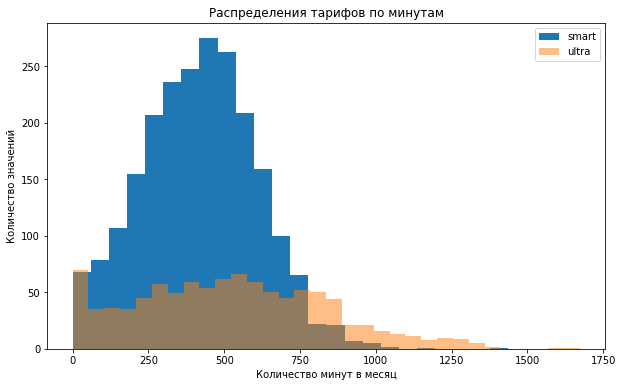

In [19]:
plt.figure(figsize=(10, 6))
user_stats.query('tariff_name == "smart"')['minutes'].plot(
    kind='hist',
    label='smart',
    bins=24)
user_stats.query('tariff_name == "ultra"')['minutes'].plot(
    kind='hist',
    label='ultra',
    alpha=0.5,
    bins=32)

plt.title('Распределения тарифов по минутам')
plt.xlabel('Количество минут в месяц')
plt.ylabel('Количество значений')
plt.legend()

Обе гистограммы скошены влево. На тарифе "Ультра" скошенность более выраженная, несмотря на большее среднее значение в **526 минут** по сравнению с медианным в **518 минут**. Гистограмма поясняет почему: значимое количество месяцев на тарифе "Ульра" имеют в активе более 1000 минут разговора. А как мы знаем, среднее чувствительно к большим значениям. Также видим всплеск в районе нулевых значений, что означает большое количество "нулевых" по минутам месяцев на тарифе "Ультра".

Таким образом на обоих тарифах пользователи предпочитают говорить меньше среднего значения. Особенно на тарифе "Ультра"

#### Итоги сравнения по количеству минут разговора

- В среднем пользователи "Ультра" говорят больше на 108 минут, чем пользователи на тарифе "Смарт".
- На тарифе "Ультра" пользователи в среднем очень далеки от того, чтобы "выговорить" пакет включенных минут **(526 из 3000)**, в отличие от пользователей "Смарт". В среднем они близки к регулярному исчерпанию минут, включенных в абонентскую плату **(418 из 500)** и наверняка часто используют больше.
- Среднее время разговора пользователей в месяц на "Ультра" более разбросано относительно общего среднего: стандартное отклонение **318** при среднем **526**. Для сравнения тариф "Смарт": стандартное отклонение **190** при среднем **418**
- На обоих тарифах большее количество пользователей предпочитает говорить меньше среднего.

### Сравнение тарифов по количеству сообщений

In [20]:
agg_func_describe = {'messages': ['describe']}
display(user_stats.groupby(['tariff_name']).agg(agg_func_describe).round(2))

messages_smart_var = user_stats.query('tariff_name == "smart"')['messages'].var().round(2)
messages_ultra_var = user_stats.query('tariff_name == "ultra"')['messages'].var().round(2)
print(f'Дисперсия по количеству сообщений в месяц на тарифе "Смарт": {messages_smart_var}')
print(f'Дисперсия по количеству сообщений в месяц на тарифе "Ультра": {messages_ultra_var}')

messages                                             
            describe                                             
               count   mean    std  min   25%   50%    75%    max
tariff_name                                                      
smart         2230.0  33.37  28.23  0.0  10.0  28.0  51.00  143.0
ultra          986.0  49.31  47.81  0.0   6.0  38.0  78.75  224.0

Дисперсия по количеству сообщений в месяц на тарифе "Смарт": 796.96
Дисперсия по количеству сообщений в месяц на тарифе "Ультра": 2285.42


- Среднее количество сообщений: "Смарт" - 33; "Ультра" - 49. 
- Стандартное отклонение: "Смарт" - 28; "Ультра" - 47. По степени разброса количества сообщений относительно среднего на обоих тарифах сопоставимое. 

Взглянем на гистограммы:

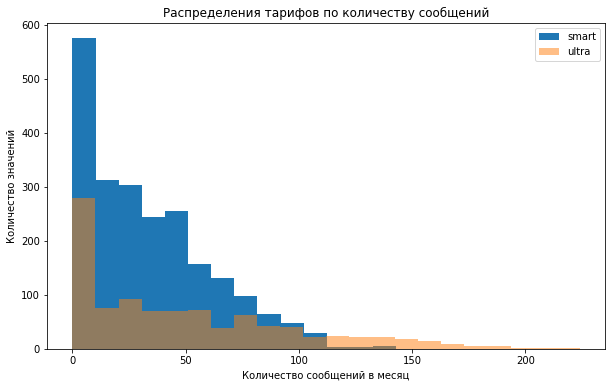

In [21]:
plt.figure(figsize=(10, 6))
user_stats.query('tariff_name == "smart"')['messages'].plot(
    kind='hist',
    label='smart',
    bins=14)
user_stats.query('tariff_name == "ultra"')['messages'].plot(
    kind='hist',
    label='ultra',
    alpha=0.5,
    bins=22)

plt.title('Распределения тарифов по количеству сообщений')
plt.xlabel('Количество сообщений в месяц')
plt.ylabel('Количество значений')
plt.legend()

Гистограммы похожи на нормальное распределение сдвинутое влево. Подавляющее большинство пользователей отправляют ежемесячно 100 сообщений и меньше. Ярковыраженный пик в районе нулевых значений на обоих тарифах - услуга непопулярна. Особенно на тарифе "Ультра"

#### Сравнение тарифов по количеству сообщений

- В среднем больше сообщений отправляется пользователями тарифа "Ультра" **(49 против 33 на "Смарт")**. Но если на "Ультра" ни разу за год не превышли предоставленный лимит в 1000 сообщений, то на "Смарт" достаточно часто больше 50 смс отправляется. Это подтверждает гистограмма.
- Данные в одинаковой степени разбросаны от среднего, а гистограммы сдвинуты влево с пиком в районе нулевых значений. Услуга непопулярна, особенно на тарифе "Ультра"

### Сравнение тарифов по объёму интернет-трафика

In [22]:
agg_func_describe = {'gb_used': ['describe']}
display(user_stats.groupby(['tariff_name']).agg(agg_func_describe).round(2))

gb_used_smart_var = user_stats.query('tariff_name == "smart"')['gb_used'].var().round(2)
gb_used_ultra_var = user_stats.query('tariff_name == "ultra"')['gb_used'].var().round(2)
print(f'Дисперсия по количеству Гб интернета в месяц на тарифе "Смарт": {gb_used_smart_var}')
print(f'Дисперсия по количеству Гб интернета в месяц на тарифе "Ультра": {gb_used_ultra_var}')

gb_used                                          
            describe                                          
               count   mean   std  min   25%   50%   75%   max
tariff_name                                                   
smart         2230.0  16.32  5.76  0.0  13.0  17.0  20.0  38.0
ultra          986.0  19.47  9.87  0.0  12.0  19.0  27.0  49.0

Дисперсия по количеству Гб интернета в месяц на тарифе "Смарт": 33.13
Дисперсия по количеству Гб интернета в месяц на тарифе "Ультра": 97.38


- Среднее на тарифе "Смарт" - **16 Гб**. Это выше предоставленного **лимита в 15 Гб**. Это означает, что лимит превышается чаще, чем не превышается, а значит чаще доплачивают сверх тарифа.
- Среднее на тарифе "Ультра" - **19 Гб**. Это прилично меньше предоставленного **лимита в 30 Гб**.
- Стандартное отклонение на "Смарт" небольшое - **6 Гб** (примерно треть от среднего). А вот на "Ультра" - **10 Гб** (больше половины от среднего). То есть разброс значений на более дорогом тарифе бОльший.

Взглянем на гистограммы:

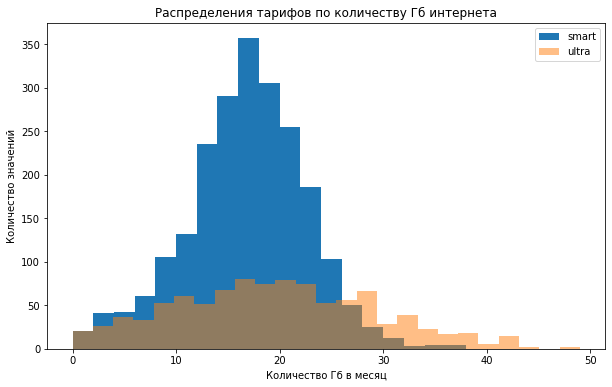

In [23]:
plt.figure(figsize=(10, 6))
user_stats.query('tariff_name == "smart"')['gb_used'].plot(
    kind='hist',
    label='smart',
    bins=19)
user_stats.query('tariff_name == "ultra"')['gb_used'].plot(
    kind='hist',
    label='ultra',
    alpha=0.5,
    bins=25)

plt.title('Распределения тарифов по количеству Гб интернета')
plt.xlabel('Количество Гб в месяц')
plt.ylabel('Количество значений')
plt.legend()

- Гистограммы похожи на нормальные распределения.
- Гистограмма по тарифу "Смарт" чуть скошена вправо. Большее количество месяцев включают в себя оплату за доп. мегабайты.
- Гистограмма по тарифу "Ультра" скошена влево. Большее количество месяцев **не** включают в себя оплату за доп. мегабайты. Кроме того, наблюдается всплеск прямо перед значением лимита в 30 Гб. Значит на "Ультра" стараются лимит не превышать.

#### Итоги сравнения тарифов по объёму интернет-трафика

- Пользователи тарифа "Смарт" в среднем меньше пользуются интернетом (16 Гб против 19 Гб на "Смарт), но гораздо чаще вылазят за рамки оплаченного пакета и платят дополнительно.
- Пользователи обоих тарифов стремятся остаться в пределах предоставленного пакета гигабайт. Правда на "Смарте" не очень получается - об этом говорит среднее больше лимита в 15 Гб. Пользователи же "Ультра" гораздо реже вылезают за пределы лимита.

### Общие итоги анализа

- Мы видим, что наиболее популярная услуга - интернет. Наименее полпулярная - смс.
- Пользователи "Ультра" используют на 108 минут разговора больше, на 16 сообщений больше и на 3 гигабайта интернет-трафика больше, но редко исчерпывают предоставленные лимиты
- Пользователи обоих тарифов следят за соблюдением лимитов, но пользователи "Смарт" чаще вылазят за предоставленные лимиты и гораздо чаще доплачивают сверх абонентской платы. Особенно за интернет.

## Проверка гипотез

### Выручка пользователей "Ультра" и "Смарт"

Сформулируем нулевую гипотезу (она должна подразумевать некое равенство):
**Средняя выручка от пользователей тарифа "Ультра" равна средней выручке от пользователей тарифа "Смарт"**.

Проверим её и другие гипотезы с помощью st.ttest_ind, т.к. будем сравнивать выборочные средние двух независимых выборок:

In [24]:
# Формируем выборки по тарифам
fee_ultra = user_stats_fee.query('tariff_name == "ultra"')['rub_monthly_fee']
fee_smart = user_stats_fee.query('tariff_name == "smart"')['rub_monthly_fee']


alpha = .01 # критический уровень статистической значимости в один процент для точности
            

results = st.ttest_ind(
    fee_smart, 
    fee_ultra)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем предположение, что средние выручки тарифов равны")
else:
    print("Вполне вероятно, что средние выручки тарифов равны")

p-значение: 8.081909555489933e-161
Отвергаем предположение, что средние выручки тарифов равны


Нулевая гипотеза опровергнута. Проверим одностороннюю альтернативную гипотезу, чтобы определить, какой тариф лучше для оператора:
**Средняя выручка от пользователя тарифа "Смарт" меньше выручки от пользователя тарифа "Ультра"**

In [25]:
results = st.ttest_ind(
    fee_smart, 
    fee_ultra)

print('p-значение:', results.pvalue / 2) #уменьшаем p-значение в 2 раза т.к. альтернаивная гипотеза односторонняя

# кроме сравнения р-значения с уровнем статистической значимости сравниваем средние по выборкам
if (results.pvalue / 2 < alpha) and (fee_smart.mean() < fee_ultra.mean()):
    print('Выручка по тарифу "Смарт" значимо меньше выручки по тарифу "Ультра"')
else:
    print("Вполне вероятно, что средние выручки тарифов равны")

p-значение: 4.0409547777449665e-161
Выручка по тарифу "Смарт" значимо меньше выручки по тарифу "Ультра"


По выручке тариф "Ультра" лучше "Смарта"

### Выручка пользователей из Москвы и других регионов

Сформулируем нулевую гипотезу: **средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов.**

In [26]:
# формируем выборки по Москве и регионам
fee_moscow = user_stats_fee.query('city == "Москва"')['rub_monthly_fee']
fee_region = user_stats_fee.query('city != "Москва"')['rub_monthly_fee']

alpha = .01 # точность наше всё            

results = st.ttest_ind(
    fee_moscow, 
    fee_region)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем предположение, что средняя выручка по Москве равна средней выручке в регионах")
else:
    print("Вполне вероятно, что средние выручки в Москве и регионах равны")

p-значение: 0.5400751614511182
Вполне вероятно, что средние выручки в Москве и регионах равны


Отвергнуть нулевую гипотезу мы не можем.

## Общий вывод

Первичное знакомство с данными показало, что исходная информация предоставлена в отличном состоянии. Исправить пришлось только типы данных по большому счёту. Тем не менее данные в разных таблицах заставили изрядно поработать над расчётами. 

**Анализ показал:**
- наиболее популярная услуга - интернет.
- в среднем пользователи "Ультра" используют на 108 минут разговора больше, на 16 сообщений больше и на 3 гигабайта интернет-трафика больше, но редко исчерпывают предоставленные лимиты
- пользователи "Смарт" чаще вылазят за предоставленные лимиты и гораздо чаще доплачивают сверх абонентской платы. Особенно за интернет.

**Проверка гипотез дала следующие результаты:**
- средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются - **подтверждена**.
- средняя выручка пользователей тарифа «Смарт» меньше, чем «Ультра» - **подтверждена**.
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов - **опровергнута**

Таким образом, **лучший тариф "Ультра"**, но вцелом по РФ среднемесячная выручка от "Смарт" сопоставима с "Ультра" и в связке эти тарифы добавляют стабильности прибылей. Отказываться от "умных" не стоит.
Значит, логично скорректировать рекламный бюджет в сторону размещения предложений тарифа "Ультра" по РФ.